In [1]:
import torch
import pandas as pd
import numpy as np
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import ViTForImageClassification
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import wandb
import torch.nn.functional as F
import timm
from torch import nn
from sklearn.metrics import roc_curve
import math
from albumentations import (
    Compose, RandomResizedCrop, HorizontalFlip, VerticalFlip,
    RandomRotate90, ElasticTransform, GridDistortion,
    ColorJitter, RandomBrightnessContrast, GaussNoise)
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
drive.mount('/content/drive')
image_folder = '/content/drive/MyDrive/Курсовая/images/'
masks_folder = '/content/drive/MyDrive/Курсовая/masks_full/'
metadata_path = '/content/drive/MyDrive/Курсовая/HAM10000_metadata.tab'
ISIC2017_malignant  = '/content/drive/MyDrive/Курсовая/ISIC_2017_only_malignant/'
masks_ISIC2017_malignant = '/content/drive/MyDrive/Курсовая/ISIC_2017_only_malignant_masks/'
ISIC2017_malignant_5703 = '/content/drive/MyDrive/Курсовая/ISIC_malignant_5703/'
masks_ISIC2017_malignant_5703 = '/content/drive/MyDrive/Курсовая/ISIC_malignant_5703_masksbymodel/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv(metadata_path, sep='\t', header=None)
df.columns = ['lesion_id', 'image_id', 'diagnosis', 'type_of_diagnostic', 'age', 'sex', 'localization', 'source']
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_folder, x + '.jpg'))
df['mask_path'] = df['image_id'].apply(lambda x: os.path.join(masks_folder, x + '.png'))
benign_diagnoses = ['bkl', 'nv', 'df', 'vasc']  # доброкачественные будут 0, злокачественные 1
df['label'] = df['diagnosis'].apply(lambda x: 0 if x in benign_diagnoses else 1)
df.drop(columns=['diagnosis'], inplace=True)
df.head()

,lesion_id,image_id,type_of_diagnostic,age,sex,localization,source,image_path,mask_path,label
0,HAM_0000118,ISIC_0027419,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
1,HAM_0000118,ISIC_0025030,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
2,HAM_0002730,ISIC_0026769,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
3,HAM_0002730,ISIC_0025661,histo,80.0,male,scalp,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0
4,HAM_0001466,ISIC_0031633,histo,75.0,male,ear,vidir_modern,/content/drive/MyDrive/Курсовая/images/ISIC_00...,/content/drive/MyDrive/Курсовая/masks_full/ISI...,0


In [4]:
benign_count = df[df['label'] == 0].shape[0]
malignant_count = df[df['label'] == 1].shape[0]
print(f'Доброкачественных: {benign_count}')
print(f'Злокачественных: {malignant_count}')
print(f'Недостаток злокачественных данных: {benign_count - malignant_count}')

Доброкачественных: 8061
Злокачественных: 1954
Недостаток злокачественных данных: 6107


In [5]:
# добавляем данные о malignant и их масках из ISIC2017

image_ids = [os.path.splitext(f)[0] for f in os.listdir(ISIC2017_malignant) if f.lower().endswith('.jpg')]
df_new = pd.DataFrame({'image_id': image_ids,
                       'image_path' : [os.path.join(ISIC2017_malignant, img + '.jpg') for img in image_ids],
                       'mask_path' : [os.path.join(masks_ISIC2017_malignant, img + '.png') for img in image_ids],
                       'label' : 1})

for col in ['lesion_id', 'type_of_diagnostic', 'age', 'sex', 'localization', 'source']:
    df_new[col] = None
cols = df.columns.tolist()
df_new = df_new[cols]
df = pd.concat([df, df_new], ignore_index=True)
df.tail()

<ipython-input-5-fc4f626e0cc0>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new], ignore_index=True)


,lesion_id,image_id,type_of_diagnostic,age,sex,localization,source,image_path,mask_path,label
10414,None,ISIC_0015190,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1
10415,None,ISIC_0015082,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1
10416,None,ISIC_0015200,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1
10417,None,ISIC_0015204,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1
10418,None,ISIC_0015110,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,/content/drive/MyDrive/Курсовая/ISIC_2017_only...,1


In [6]:
benign_count = df[df['label'] == 0].shape[0]
malignant_count = df[df['label'] == 1].shape[0]
print(f'Доброкачественных: {benign_count}')
print(f'Злокачественных: {malignant_count}')
print(f'Недостаток злокачественных данных: {benign_count - malignant_count}')

Доброкачественных: 8061
Злокачественных: 2358
Недостаток злокачественных данных: 5703


In [7]:
# добавляем данные о malignant (рандомные из ISIC) и их масках (сформированные моделью сегментации)

image_ids = [os.path.splitext(f)[0] for f in os.listdir(ISIC2017_malignant_5703) if f.lower().endswith('.jpg')]
df_new = pd.DataFrame({'image_id': image_ids,
                       'image_path' : [os.path.join(ISIC2017_malignant_5703, img + '.jpg') for img in image_ids],
                       'mask_path' : [os.path.join(masks_ISIC2017_malignant_5703, img + '.png') for img in image_ids],
                       'label' : 1})

for col in ['lesion_id', 'type_of_diagnostic', 'age', 'sex', 'localization', 'source']:
    df_new[col] = None
cols = df.columns.tolist()
df_new = df_new[cols]
df = pd.concat([df, df_new], ignore_index=True)
df.tail()

<ipython-input-7-c74d0a5c28a0>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, df_new], ignore_index=True)


,lesion_id,image_id,type_of_diagnostic,age,sex,localization,source,image_path,mask_path,label
16117,None,ISIC_0057224,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1
16118,None,ISIC_0055854,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1
16119,None,ISIC_0056799,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1
16120,None,ISIC_0054991,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1
16121,None,ISIC_0021576,None,NaN,None,None,None,/content/drive/MyDrive/Курсовая/ISIC_malignant...,/content/drive/MyDrive/Курсовая/ISIC_malignant...,1


In [8]:
benign_count = df[df['label'] == 0].shape[0]
malignant_count = df[df['label'] == 1].shape[0]
print(f'Доброкачественных: {benign_count}')
print(f'Злокачественных: {malignant_count}')
print(f'Недостаток злокачественных данных: {benign_count - malignant_count}')

Доброкачественных: 8061
Злокачественных: 8061
Недостаток злокачественных данных: 0


In [9]:
train_df, tmp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['label'], random_state=42)

In [10]:
wandb.init(project="skin_lesion_classification", config={
    "learning_rate": 0.0001,
    "epochs": 100,
    "batch_size": 32,
    "architecture": "vit",
    "dataset": "HAM10000+ISIC"})

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kalinicheva2007 (pdftotex) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [11]:
config = wandb.config

In [12]:
class ViTWithMask(torch.nn.Module):
    def __init__(self, vit_model):
        super(ViTWithMask, self).__init__()
        self.vit = vit_model

    def forward(self, pixel_values, seg_mask=None):
        # embeddings = self.vit.embeddings(pixel_values)
        embeddings = self.vit.vit.embeddings(pixel_values)
        if isinstance(embeddings, tuple):
            embeddings = embeddings[0]

        if seg_mask is not None:
            patch_size = self.vit.config.patch_size
            B, C, H, W = pixel_values.shape
            new_H, new_W = H // patch_size, W // patch_size

            seg_mask_resized = F.interpolate(seg_mask, size=(new_H, new_W), mode='nearest')
            seg_mask_flat = seg_mask_resized.view(B, -1)
            ones = torch.ones(B, 1, device=seg_mask_flat.device)
            seg_mask_flat = torch.cat([ones, seg_mask_flat], dim=1)
            seg_mask_flat = seg_mask_flat.float().unsqueeze(-1)
            embeddings = embeddings * seg_mask_flat

        # encoder_outputs = self.vit.encoder(embeddings)
        encoder_outputs = self.vit.vit.encoder(embeddings)
        if isinstance(encoder_outputs, tuple):
            hidden_states = encoder_outputs[0]
        else:
            hidden_states = encoder_outputs.last_hidden_state

        # cls_output = encoder_outputs[:, 0]
        cls_output = hidden_states[:, 0]
        if hasattr(self.vit, 'layernorm'):
            cls_output = self.vit.layernorm(cls_output)
        elif hasattr(self.vit, 'layer_norm'):
            cls_output = self.vit.layer_norm(cls_output)
        # else:
        #    pass
        # cls_output = self.vit.layernorm(cls_output)
        logits = self.vit.classifier(cls_output)
        return logits

In [13]:
class SkinLesionDataset(Dataset):
    def __init__(self, dataframe, image_transform=None, mask_transform=None):
        self.dataframe = dataframe
        self.image_transform = image_transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        mask_path = self.dataframe.iloc[idx]['mask_path']
        label = self.dataframe.iloc[idx]['label']

        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask, label


image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST),
    transforms.ToTensor()])

loader_kwargs = {'batch_size': config.batch_size, 'num_workers': 8, 'pin_memory': True, 'prefetch_factor': 2, 'persistent_workers': True}

train_dataset = SkinLesionDataset(train_df, image_transform=image_transform, mask_transform=mask_transform)
val_dataset = SkinLesionDataset(val_df, image_transform=image_transform, mask_transform=mask_transform)
test_dataset = SkinLesionDataset(test_df, image_transform=image_transform, mask_transform=mask_transform)

'''train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)'''

train_dataloader = DataLoader(train_dataset, shuffle=True, drop_last=True, **loader_kwargs)
val_dataloader = DataLoader(val_dataset, shuffle=False, drop_last=False, **loader_kwargs)
test_dataloader = DataLoader(test_dataset, shuffle=False, drop_last=False, **loader_kwargs)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name, num_labels=2).to(device)  # бинарная

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
model = ViTWithMask(model).to(device)

In [16]:
criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

In [17]:
def custom_loss(outputs, targets, lambda_factor=5.0):  # лямбда фактор - штраф
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')  # чтобы навесить штраф, мы должны знать потери для каждого образца
    probs = torch.softmax(outputs, dim=1)
    malignant_mask = (targets == 1)
    # наказываем только false-negative результаты, доброкачественные новообразования получают обычную кросс-энтропию
    penalty = torch.zeros_like(ce_loss)
    penalty[malignant_mask] = lambda_factor * (1 - probs[malignant_mask, 1])
    loss = ce_loss + penalty
    return loss.mean()

def improved_loss(outputs, targets, lambda_factor=5.0, gamma=2.0):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    probs = torch.softmax(outputs, dim=1)
    penalty = torch.zeros_like(ce_loss)
    malignant_mask = (targets == 1)
    penalty[malignant_mask] = lambda_factor * (1 - probs[malignant_mask, 1]) ** gamma
    loss = ce_loss + penalty
    return loss.mean()

def focal_loss(outputs, targets, alpha=0.25, gamma=2.0):
    ce = F.cross_entropy(outputs, targets, reduction='none')
    pt = torch.exp(-ce)
    loss = alpha * (1 - pt)**gamma * ce
    return loss.mean()

def focal_loss_new(outputs, targets, alpha=0.25, gamma=2.0):
    ce_loss = F.cross_entropy(outputs, targets, reduction='none')
    probs = torch.softmax(outputs, dim=1)
    pt = probs[range(len(targets)), targets]
    alpha_factor = torch.where(targets==1, alpha, 1-alpha)
    focal_weight = alpha_factor * (1 - pt) ** gamma
    loss = focal_weight * ce_loss
    return loss.mean()

In [18]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0, verbose=False, save_path='best_model.pth'):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.save_path = save_path
        self.best_loss = float('inf')
        self.best_f1 = 0.0
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_f1):
        if val_f1 > self.best_f1 + self.delta:
            self.best_f1 = val_f1
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter): {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.save_path)
        if self.verbose:
            print(f'Сохранены новые лучшие веса модели в: {self.save_path}')

    def load_best_model(self, model):
        model.load_state_dict(torch.load(self.save_path))
        if self.verbose:
            print(f'Загружены лучшие веса модели из: {self.save_path}')

In [19]:
def evaluate(model, dataloader, threshold=0.5):
    model.eval()
    total_loss = 0.0
    total = tp = fn = fp = 0
    with torch.no_grad():
        for images, masks, labels in dataloader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, seg_mask=masks)
            # loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0)
            loss = focal_loss_new(outputs, labels, alpha=0.25, gamma=2.0)
            total_loss += loss.item() * labels.size(0)
            probs = torch.softmax(outputs, dim=1)
            preds = (probs[:,1] > threshold).long()

            total += labels.size(0)
            # correct += (preds == labels).sum().item()

            tp += ((preds == 1) & (labels == 1)).sum().item()
            fn += ((preds == 0) & (labels == 1)).sum().item()
            fp += ((preds == 1) & (labels == 0)).sum().item()

    avg_loss = total_loss / total
    # accuracy = 100 * correct / total
    # recall = 100 * tp / (tp + fn + 1e-8)
    # return avg_loss, accuracy, recall
    recall = 100 * tp / (tp + fn + 1e-8)
    precision = 100 * tp / (tp + fp + 1e-8)
    '''beta2 = 4.0
    f2 = (1 + beta2) * precision * recall / (beta2 * precision + recall + 1e-8)'''
    f1 = 2 * precision * recall / (precision + recall + 1e-8)
    accuracy = 100 * (tp + (total - tp - fn - fp)) / total
    return avg_loss, accuracy, recall, precision, f1

In [20]:
def train_model(num_epochs, model, threshold):
    early_stopping = EarlyStopping(patience=5, delta=0.1, verbose=True, save_path='best_model.pth')
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for batch_idx, (images, masks, labels) in enumerate(train_dataloader):
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images, seg_mask=masks)
            # loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0)
            loss = focal_loss_new(outputs, labels, alpha=0.25, gamma=2.0)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)

            probs = torch.softmax(outputs, dim=1)
            preds = (probs[:,1] > 0.5).long()
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}')
        train_loss = running_loss / total
        train_accuracy = 100 * correct / total

        val_loss, val_acc, val_rec, val_prec, val_f1 = evaluate(model, val_dataloader, threshold=threshold)

        wandb.log({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_acc,
            'val_recall': val_rec,
            'val_precision': val_prec,
            'val_f1': val_f1})

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Recall: {val_rec:.2f}%,  Val F1: {val_f1:.2f}')

        if early_stopping(model, val_f1):
            print('Early stopping triggered...')
            break

    early_stopping.load_best_model(model)

In [21]:
train_model(num_epochs=config.epochs, model=model, threshold=0.5)

Epoch 1, Batch 0/352
Epoch 1, Batch 10/352
Epoch 1, Batch 20/352
Epoch 1, Batch 30/352
Epoch 1, Batch 40/352
Epoch 1, Batch 50/352
Epoch 1, Batch 60/352
Epoch 1, Batch 70/352
Epoch 1, Batch 80/352
Epoch 1, Batch 90/352
Epoch 1, Batch 100/352
Epoch 1, Batch 110/352
Epoch 1, Batch 120/352
Epoch 1, Batch 130/352
Epoch 1, Batch 140/352
Epoch 1, Batch 150/352
Epoch 1, Batch 160/352
Epoch 1, Batch 170/352
Epoch 1, Batch 180/352
Epoch 1, Batch 190/352
Epoch 1, Batch 200/352
Epoch 1, Batch 210/352
Epoch 1, Batch 220/352
Epoch 1, Batch 230/352
Epoch 1, Batch 240/352
Epoch 1, Batch 250/352
Epoch 1, Batch 260/352
Epoch 1, Batch 270/352
Epoch 1, Batch 280/352
Epoch 1, Batch 290/352
Epoch 1, Batch 300/352
Epoch 1, Batch 310/352
Epoch 1, Batch 320/352
Epoch 1, Batch 330/352
Epoch 1, Batch 340/352
Epoch 1, Batch 350/352
Epoch 1/100, Train Loss: 0.3374, Train Acc: 77.59%, Val Loss: 0.0327, Val Acc: 84.28%, Val Recall: 72.95%,  Val F1: 82.28
Сохранены новые лучшие веса модели в: best_model.pth
Epoch 2,

In [22]:
model.load_state_dict(torch.load('/content/best_model.pth'))
model.to(device)

ViTWithMask(
  (vit): ViTForImageClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (intermediate): ViTIntermediate(
              (dense): Linear(

In [23]:
def evaluate_model():
    test_loss, test_accuracy, test_recall, test_prec, test_f1 = evaluate(model, test_dataloader, threshold=0.5)
    print(f'Test Loss: {test_loss:.4f}, '
          f'Acc: {test_accuracy:.2f}%, '
          f'Recall: {test_recall:.2f}%, '
          f'Precision: {test_prec:.2f}%, '
          f'F1: {test_f1:.2f}%')

evaluate_model()

Test Loss: 0.0380, Acc: 89.83%, Recall: 87.26%, Precision: 91.98%, F1: 89.56%


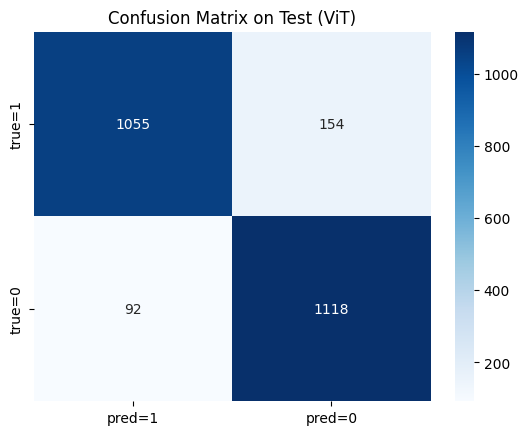

In [24]:
all_probs, all_labels = [], []
model.eval()
with torch.no_grad():
    for imgs, msks, lbls in test_dataloader:
        imgs, msks = imgs.to(device), msks.to(device)
        out = model(imgs, seg_mask=msks)
        probs = torch.softmax(out,1)[:,1].cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(lbls.numpy())

# preds = (np.array(all_probs) > best_threshold).astype(int)
preds = (np.array(all_probs) > 0.5).astype(int)
cm = confusion_matrix(all_labels, preds, labels=[1,0])  # [ [TP, FN], [FP, TN] ]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['pred=1','pred=0'], yticklabels=['true=1','true=0'])
plt.title('Confusion Matrix on Test (ViT)')
plt.show()

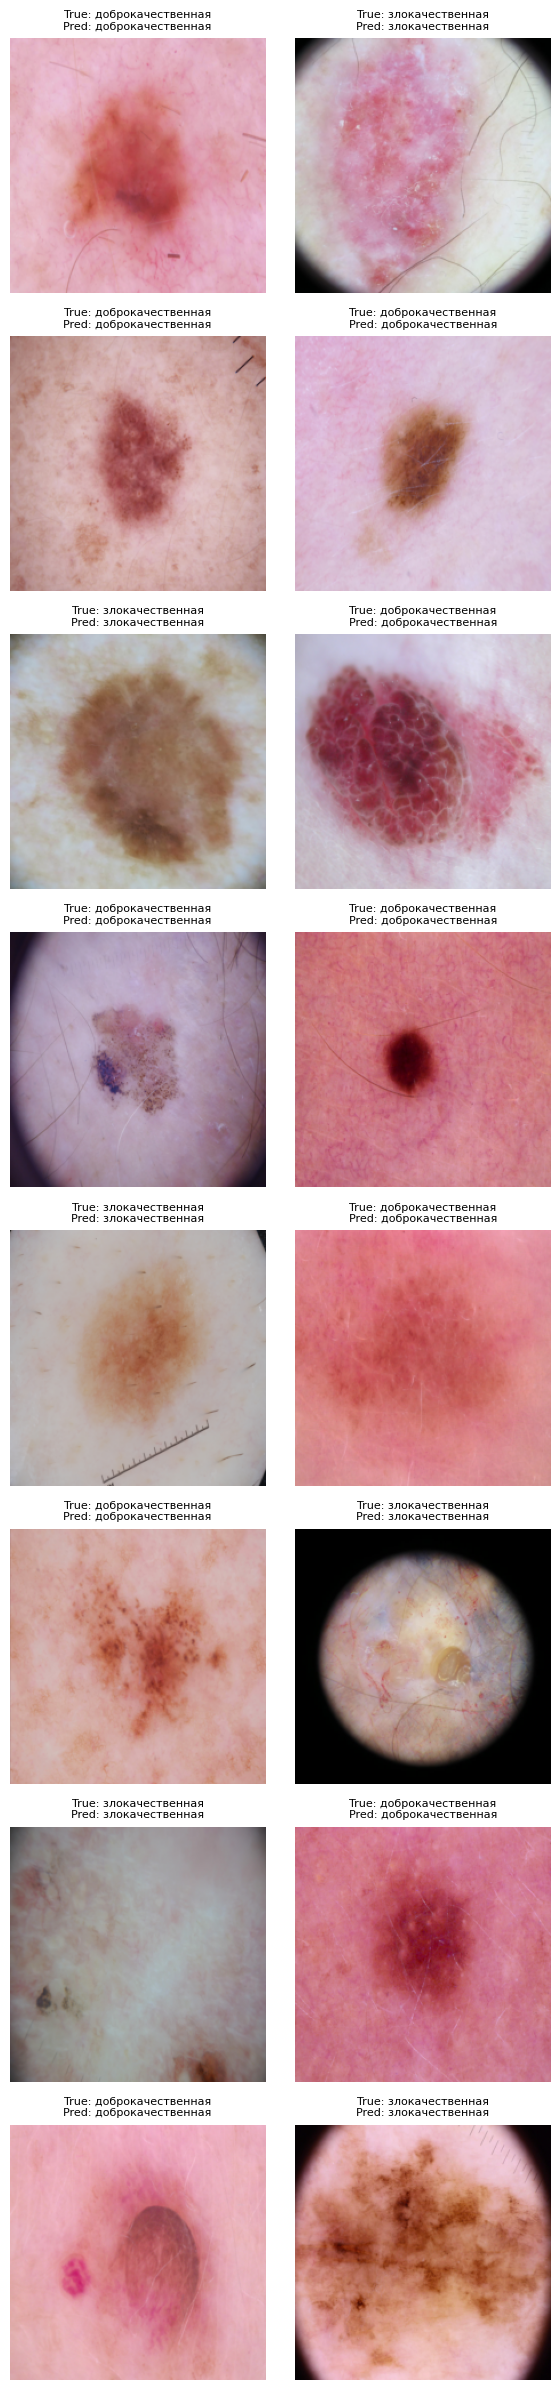

In [25]:
def visualize_predictions(model, dataloader, grid_shape=(8, 2)):
    model.eval()
    n_rows, n_cols = grid_shape
    total_images = n_rows * n_cols
    label_map = {0: 'доброкачественная', 1: 'злокачественная'}

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    # Преобразуем axes в одномерный массив для удобного перебора
    if isinstance(axes, (list, np.ndarray)):
        axes = axes.flatten()
    else:
        axes = [axes]

    images_shown = 0

    with torch.no_grad():
        for images, masks, labels in dataloader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)
            outputs = model(images, seg_mask=masks)
            _, preds = torch.max(outputs, 1)
            images = images.cpu()
            for i in range(images.shape[0]):
                if images_shown >= total_images:
                    break
                img = images[i].permute(1, 2, 0)
                img = img * 0.5 + 0.5
                ax = axes[images_shown]
                ax.imshow(img.numpy())
                true_label = label_map[labels[i].item()]
                pred_label = label_map[preds[i].item()]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
                ax.axis('off')
                images_shown += 1
            if images_shown >= total_images:
                break
    plt.tight_layout()
    plt.show()

visualize_predictions(model, test_dataloader, grid_shape=(8, 2))

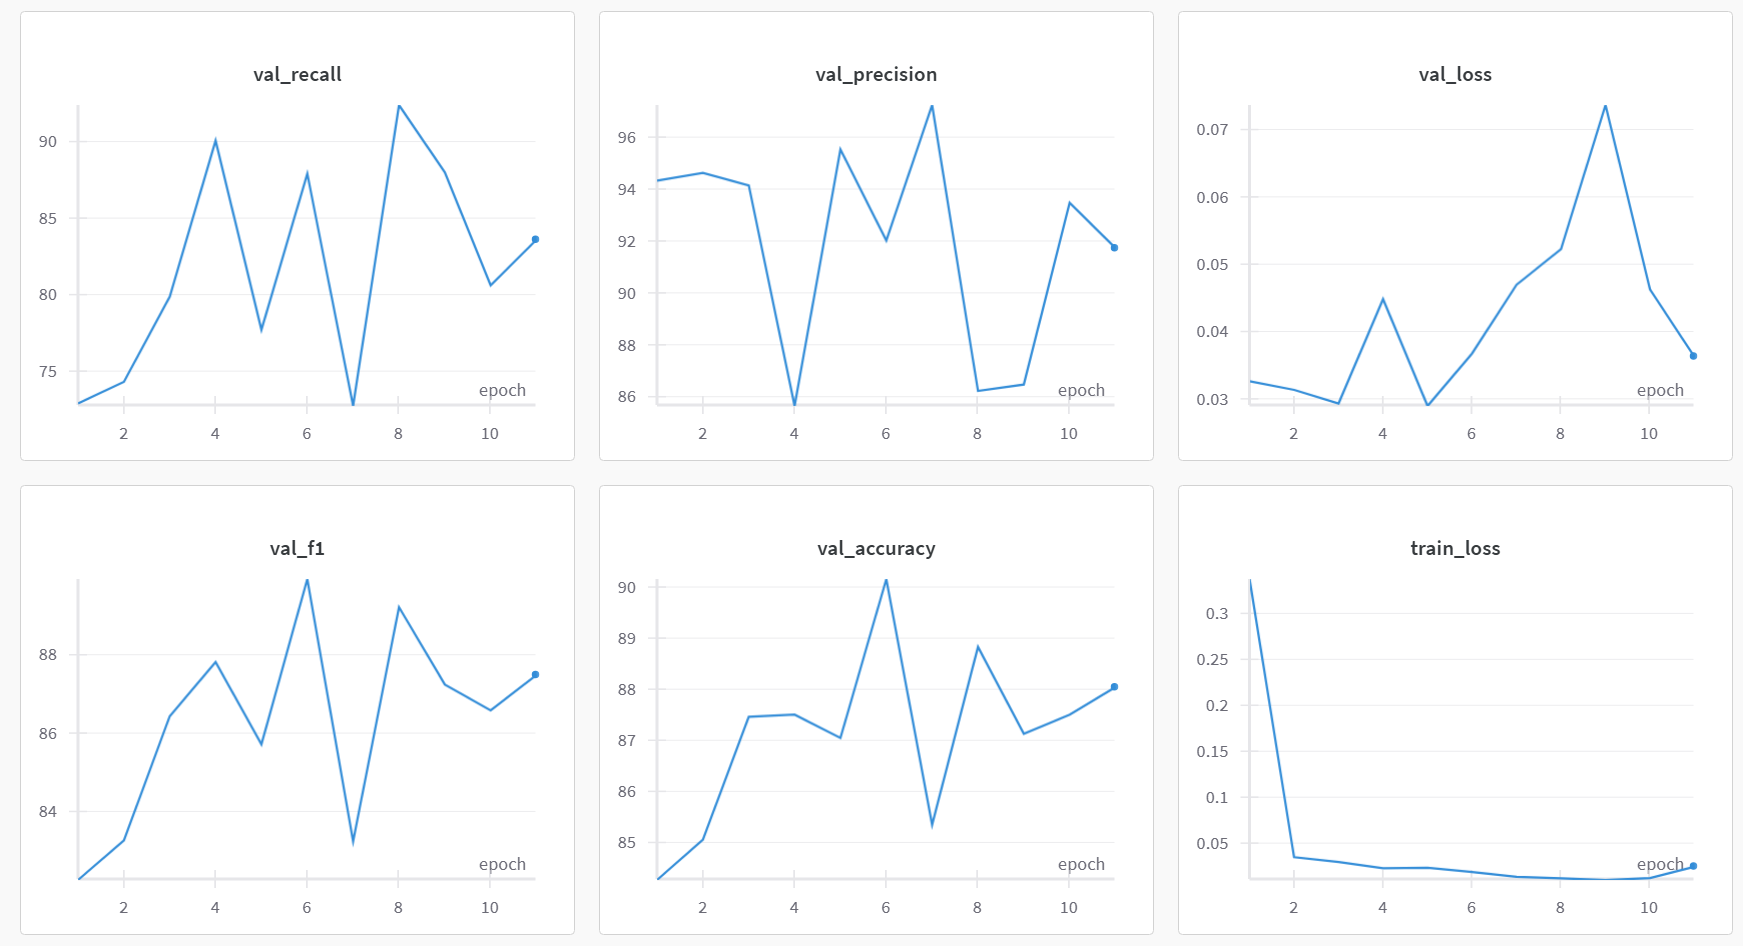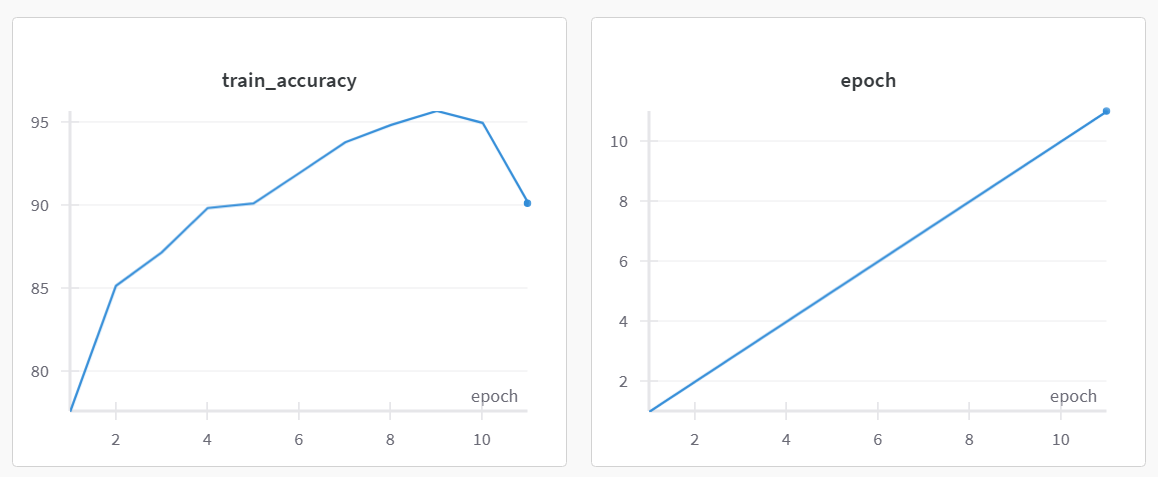

In [26]:
#T4